# BitTiger DS501 Week2

1. [Standard Normal Distribution](#Standard-Normal-Distribution)
2. [Lending club](#Week2-Lending-club)
   * [Unpaired two sample student t-test](#Unpaired-two-sample-student-t-test)
   * [Chi2](#Chi2)

# Standard Normal Distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.randn(10) # 產生 10 個遵從 standard normal 分佈的數值 

array([-1.34964075,  0.58249088, -0.24003941, -1.52440349,  0.3814614 ,
        2.11011821, -0.10270056,  0.1538655 , -0.23590997, -0.58243215])

/usr/local/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


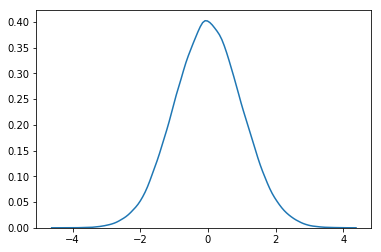

In [3]:
x = np.random.randn(100000)
sns.distplot(x, hist=False)

In [4]:
from scipy.stats import norm
norm.pdf(0)

0.3989422804014327

In [5]:
norm.cdf(0)

0.5

In [6]:
norm.ppf(0.975)

1.959963984540054

# Week2 Lending club

In [7]:
df_loan = pd.read_csv('loan.csv', low_memory=False)

In [8]:
df_loan_T = df_loan.copy()

### Unpaired two sample student t-test
* Equal variances

$$ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{s^2(\frac{1}{n_1} + \frac{1}{n_2})}} $$

$$ s^2 = \frac{\sum_{i=1}^{n_1}(x_i - \bar{x}_1)^2 + \sum_{j=1}^{n_2}(x_j - \bar{x}_2)^2}{n_1 + n_2 - 2} $$

$$ df = n_1 + n_2 - 2 $$

$$ C.I. = \bar{x} \pm t (\frac{s}{\sqrt{n}}) $$

* Unequal variances

$$ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{s^2(\frac{1}{n_1} + \frac{1}{n_2})}} $$ (t 的公式是一樣的)

$$ s_1^2 = \frac{\sum_{i=1}^{n_1}(x_i - \bar{x}_1)^2}{n_1 - 1} $$

$$ s_2^2 = \frac{\sum_{j=1}^{n_2}(x_j - \bar{x}_2)^2}{n_2 - 1} $$

$$ df = \frac{[\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}]^2}{\frac{(s_1^2/n_1)^2}{n_1 - 1} + \frac{(s_2^2/n_2)^2}{n_2 - 1}} $$

$$ C.I. = \bar{x}_1 - \bar{x}_2 \pm t_{\alpha/2, df} \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} $$

用 scipy.stats 來算 t-score 和 p-value

In [9]:
a = df_loan[df_loan['term'] == ' 36 months']['int_rate'].values
b = df_loan[df_loan['term'] == ' 60 months']['int_rate'].values

from scipy import stats
tstat, pval = stats.ttest_ind(a, b, equal_var=False)
print(tstat, pval)

-431.11699062985156 0.0


In [10]:
print(np.mean(a))
print(np.mean(b))

12.01867849466694
16.111596182592564


自己算 degree of freedom

In [11]:
def s_square(x):
    m = np.mean(x)
    n = len(x)
    sum = 0
    for i in x:
        sum += (i - m)**2
    return sum / (n - 1)

s1_square = s_square(a)
s2_square = s_square(b)

print(np.var(a), s1_square)
print(np.var(b), s2_square)

n1 = len(a)
n2 = len(b)

df = (s1_square/n1 + s2_square/n2)**2 / ((s1_square / n1)**2 / (n1 - 1) + (s2_square / n2)**2 / (n2 - 1))

print(df)

14.846095171313328 14.8461190732991
17.63376036768784 17.633826597005374
467035.96463789017


自己算 95% confidence interval

In [12]:
t_score = stats.t.ppf(1-0.025, df)
print(t_score)

1.9599690639717322


In [13]:
ma = np.mean(a)
mb = np.mean(b)

low = ma - mb - t_score * np.sqrt(s1_square/n1 + s2_square/n2)
high = ma - mb + t_score * np.sqrt(s1_square/n1 + s2_square/n2)

print(low, high)

-4.111525147673368 -4.07431022817788


自己套公式計算 t-score 和 p-value

In [14]:
short_term = df_loan[df_loan['term'] == ' 36 months']
long_term = df_loan[df_loan['term'] == ' 60 months']

std_err = np.sqrt(np.var(short_term['int_rate']) / short_term.shape[0] +
                  np.var(long_term['int_rate']) / long_term.shape[0])
print(std_err)

t = (np.mean(short_term['int_rate']) - np.mean(long_term['int_rate'])) / std_err
print(t)

p = stats.t.cdf(t, 467040)
print(p)

0.009493736631375146
-431.1176775617758
0.0


接下來要做表格，要來算 chi2

In [15]:
s1 = df_loan['term'].value_counts()
s1

 36 months    621125
 60 months    266254
Name: term, dtype: int64

In [16]:
df_loan[['term', 'grade']].groupby('term')['grade'].value_counts()

term        grade
 36 months  B        212009
            C        162420
            A        143015
            D         76687
            E         21842
            F          4466
            G           686
 60 months  C         83440
            D         62855
            E         48863
            B         42526
            F         18580
            A          5187
            G          4803
Name: grade, dtype: int64

In [17]:
df_sub1 = df_loan[['term', 'grade']].groupby('term')['grade'].value_counts().to_frame().unstack(level=1)
df_sub1

grade                                           
grade            A       B       C      D      E      F     G
term                                                         
 36 months  143015  212009  162420  76687  21842   4466   686
 60 months    5187   42526   83440  62855  48863  18580  4803

換算成百分比

In [19]:
df_sub1.loc[' 36 months'] = df_sub1.loc[' 36 months'].apply(lambda x: np.round(x / s1[0], 2))
df_sub1.loc[' 60 months'] = df_sub1.loc[' 60 months'].apply(lambda x: np.round(x / s1[1], 2))
df_sub1

grade                                    
grade          A     B     C     D     E     F     G
term                                                
 36 months  0.23  0.34  0.26  0.12  0.04  0.01  0.00
 60 months  0.02  0.16  0.31  0.24  0.18  0.07  0.02

用 scipy.stats 來計算 chi2

In [20]:
from scipy.stats import chi2_contingency
X = [[143015, 212009, 162420,  76687,  21842,   4466,    686], [5187,  42526,  83440,  62855,  48863,  18580,   4803]]
chi2, pval, dof, expected = chi2_contingency(X)
print(chi2, pval, dof)

176074.84789300518 0.0 6


In [21]:
print(1- stats.chi2.cdf(chi2, dof))

0.0


自己套公式計算 chi2

In [22]:
df_sub1['row_sum'] = df_sub1.sum(axis=1)
df_sub1.loc['col_sum'] = df_sub1.sum()
df_sub1['row_sum_percentage'] = df_sub1['row_sum'] / df_loan.shape[0]
df_sub1

grade                                     row_sum  \
grade          A     B     C     D     E     F     G           
term                                                           
 36 months  0.23  0.34  0.26  0.12  0.04  0.01  0.00     1.0   
 60 months  0.02  0.16  0.31  0.24  0.18  0.07  0.02     1.0   
col_sum     0.25  0.50  0.57  0.36  0.22  0.08  0.02     2.0   

           row_sum_percentage  
grade                          
term                           
 36 months           0.000001  
 60 months           0.000001  
col_sum              0.000002

這邊 `df_expected` 的內容不重要，我想要的只是要有相同格式的 DataFrame，表格中的數值在後面計算時會換掉

In [23]:
df_expected = df_sub1.loc[[' 36 months', ' 60 months'], ['grade']]
df_expected

grade                                    
grade          A     B     C     D     E     F     G
term                                                
 36 months  0.23  0.34  0.26  0.12  0.04  0.01  0.00
 60 months  0.02  0.16  0.31  0.24  0.18  0.07  0.02

In [24]:
df_percentage = df_sub1.loc[[' 36 months', ' 60 months'], ['row_sum_percentage']]
df_percentage

,row_sum_percentage
grade,
term,
36 months,0.000001
60 months,0.000001


In [25]:
s2 = df_percentage['row_sum_percentage']
s2

term
 36 months    0.000001
 60 months    0.000001
Name: row_sum_percentage, dtype: float64

這邊才是計算 `df_expected` 中真正的數值

In [26]:
df_expected.loc[' 36 months'] = df_sub1.loc['col_sum'].apply(lambda x: np.round(x * s2[0], 2))
df_expected.loc[' 60 months'] = df_sub1.loc['col_sum'].apply(lambda x: np.round(x * s2[1], 2))
df_expected

grade                              
grade          A    B    C    D    E    F    G
term                                          
 36 months   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 60 months   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [27]:
df_observed = df_sub1.loc[[' 36 months', ' 60 months'], ['grade']]
df_observed

grade                                    
grade          A     B     C     D     E     F     G
term                                                
 36 months  0.23  0.34  0.26  0.12  0.04  0.01  0.00
 60 months  0.02  0.16  0.31  0.24  0.18  0.07  0.02

### Chi2

算 chi2
$$ \chi^2 = \sum \frac{(Obs - Exp)^2}{Exp} $$

In [28]:
df_chi2 = ((df_observed.subtract(df_expected)).multiply(df_observed.subtract(df_expected))).divide(df_expected)
df_chi2['row_sum'] = df_chi2.sum(axis=1)
df_chi2

grade                               row_sum
grade          A    B    C    D    E    F    G        
term                                                  
 36 months   inf  inf  inf  inf  inf  inf  NaN     inf
 60 months   inf  inf  inf  inf  inf  inf  inf     inf

In [29]:
chi2 = df_chi2['row_sum'].sum()
chi2

inf

開始做 EDA

In [30]:
s3 = df_loan.nunique() # 列出每個欄位有多少個獨立的數值
s3

id                             887379
member_id                      887379
loan_amnt                        1372
funded_amnt                      1372
funded_amnt_inv                  9856
term                                2
int_rate                          542
installment                     68711
grade                               7
sub_grade                          35
emp_title                      299271
emp_length                         11
home_ownership                      6
annual_inc                      49384
verification_status                 3
issue_d                           103
loan_status                        10
pymnt_plan                          2
url                            887379
desc                           124469
purpose                            14
title                           63144
zip_code                          935
addr_state                         51
dti                              4086
delinq_2yrs                        29
earliest_cr_

In [31]:
s3[s3 == 1] # 只有一個數值的欄位

policy_code    1
dtype: int64

In [32]:
s3[s3 == df_loan.shape[0]] # 全部都是獨立的數值的欄位

id           887379
member_id    887379
url          887379
dtype: int64

In [33]:
df_loan['dti_joint'].describe()

count    509.000000
mean      18.310118
std        7.169233
min        3.000000
25%       13.200000
50%       17.610000
75%       22.650000
max       43.860000
Name: dti_joint, dtype: float64

In [34]:
df_loan['dti_joint'].isnull().sum() # 檢查有多少個空值

886870

In [35]:
condition1 = df_loan['dti_joint'].isnull()
df_loan[condition1]['application_type'].value_counts()

INDIVIDUAL    886868
JOINT              2
Name: application_type, dtype: int64

In [36]:
df_loan[['dti_joint', 'dti']].head()

,dti_joint,dti
0,NaN,27.65
1,NaN,1.00
2,NaN,8.72
3,NaN,20.00
4,NaN,17.94


In [37]:
df_loan['dti_joint'] = df_loan.apply(lambda row: 
                                     row['dti'] if np.isnan(row['dti_joint']) else row['dti_joint'], axis=1)

In [38]:
df_loan[['dti_joint', 'dti']].head()

,dti_joint,dti
0,27.65,27.65
1,1.00,1.00
2,8.72,8.72
3,20.00,20.00
4,17.94,17.94


In [39]:
df_loan[['annual_inc', 'annual_inc_joint']].head()

,annual_inc,annual_inc_joint
0,24000.0,NaN
1,30000.0,NaN
2,12252.0,NaN
3,49200.0,NaN
4,80000.0,NaN


In [40]:
df_loan['annual_inc_joint'] = df_loan.apply(lambda row:
                                            row['annual_inc'] if np.isnan(row['annual_inc_joint']) else row['annual_inc_joint'], axis=1)

In [41]:
df_loan[['annual_inc', 'annual_inc_joint']].head()

,annual_inc,annual_inc_joint
0,24000.0,24000.0
1,30000.0,30000.0
2,12252.0,12252.0
3,49200.0,49200.0
4,80000.0,80000.0


In [42]:
df_loan[['home_ownership']].head()

,home_ownership
0,RENT
1,RENT
2,RENT
3,RENT
4,RENT


In [43]:
def home_ownership(row):
    if row['home_ownership'] in ['ANY', 'NONE', 'OTHER']:
        return 'OTHER'
    else:
        return row['home_ownership']
df_loan['home_ownership'] = df_loan.apply(home_ownership, axis=1)
df_loan[['home_ownership']].head()

,home_ownership
0,RENT
1,RENT
2,RENT
3,RENT
4,RENT


In [44]:
df_loan.groupby('addr_state')['int_rate'].mean()

addr_state
AK    13.639791
AL    13.757150
AR    13.458215
AZ    13.131357
CA    13.161718
CO    13.074323
CT    13.068787
DC    12.756838
DE    13.453246
FL    13.272852
GA    13.273004
HI    13.922619
IA    12.631429
ID    11.345833
IL    13.096091
IN    13.463229
KS    13.280913
KY    13.340130
LA    13.348598
MA    12.661661
MD    13.380040
ME    12.464610
MI    13.296108
MN    13.150752
MO    13.246034
MS    13.476719
MT    13.068851
NC    13.422175
ND    12.900522
NE    12.960323
NH    12.852306
NJ    13.150185
NM    13.327109
NV    13.470705
NY    13.326871
OH    13.332359
OK    13.477952
OR    13.140087
PA    13.332582
RI    13.087657
SC    13.475563
SD    13.426259
TN    13.575913
TX    13.160487
UT    13.346312
VA    13.288569
VT    12.962315
WA    13.402623
WI    12.983013
WV    13.354781
WY    13.366775
Name: int_rate, dtype: float64

In [45]:
df_state = df_loan.groupby('addr_state')['int_rate'].mean().to_frame()
df_state.head()

,int_rate
addr_state,
AK,13.639791
AL,13.757150
AR,13.458215
AZ,13.131357
CA,13.161718


In [46]:
df_state['int_rate'].quantile([0.25, 0.5, 0.75])

0.25    13.080990
0.50    13.288569
0.75    13.412399
Name: int_rate, dtype: float64

In [47]:
def int_rate_range(x):
    if x < df_state['int_rate'].quantile(0.25):
        return 'low'
    elif x < df_state['int_rate'].quantile(0.5):
        return 'lowmedium'
    elif x < df_state['int_rate'].quantile(0.75):
        return 'medium'
    else:
        return 'high'
df_state['stat_mean_int'] = df_state['int_rate'].apply(int_rate_range)
df_state

,int_rate,stat_mean_int
addr_state,,
AK,13.639791,high
AL,13.757150,high
AR,13.458215,high
AZ,13.131357,lowmedium
CA,13.161718,lowmedium
CO,13.074323,low
CT,13.068787,low
DC,12.756838,low
DE,13.453246,high
